### Load data

In [ ]:
import os
import pandas as pd
import re

In [ ]:
def get_text(path):
    with open(path) as f:
        data = f.read()
    return data



path_train_neg = '../res/aclImdb/train/neg/'
path_train_pos = '../res/aclImdb/train/pos/'

train = [{'Class': 0, 'text': get_text(path_train_neg + x), } for x in os.listdir(path_train_neg)]\
+ [{'Class': 1, 'text': get_text(path_train_pos + x)} for x in os.listdir(path_train_pos)]


path_test_neg = '../res/aclImdb/test/neg/'
path_test_pos = '../res/aclImdb/test/pos/'


test = [{'Class': 0, 'text': get_text(path_test_neg + x), } for x in os.listdir(path_test_neg)]\
+ [{'Class': 1, 'text': get_text(path_test_pos + x)} for x in os.listdir(path_test_pos)]

In [ ]:
df = pd.DataFrame(train)

In [ ]:
from nltk import word_tokenize


def preprocess_reviews(reviews):
    reviews = re.sub("(<br\s*/><br\s*/>)|(\-)|(\/)", ' ', reviews)
    return " ".join(reviews.split())

df.text = df.text.apply(preprocess_reviews)
df['tokenize'] = df.text.apply(word_tokenize)


In [ ]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords


wnl = WordNetLemmatizer()
def lemmatizer(tokens):
    res = []
    for token in tokens:
        token = re.sub("[\W\d]", '', token.lower())
        if token not in stopwords.words('english') and token != '':
            if wnl.lemmatize(token, pos='v') == token:
                res.append(wnl.lemmatize(token, pos='n'))
            else:
                res.append(wnl.lemmatize(token, pos='v'))
        else:
            continue
    return res

df['clean_review'] = df.tokenize.apply(lemmatizer, )
df.to_json('data.json')

In [16]:
import pandas as pd

df = pd.read_json('../res/data.json', )
df['clean_review'] = df.clean_review.apply(' '.join)
df.head()

,Class,text,tokenize,clean_review
0,0,Working with one of the best Shakespeare sourc...,"[Working, with, one, of, the, best, Shakespear...",work one best shakespeare source film manage c...
1,0,"Well...tremors I, the original started off in ...","[Well, ..., tremors, I, ,, the, original, star...",well tremor original start find movie quite en...
10,0,"I felt brain dead, I'll tell you. This is the ...","[I, felt, brain, dead, ,, I, 'll, tell, you, ....",felt brain dead tell worst film ever buy ignor...
100,0,"Really an amazing pile of pap! A predictable, ...","[Really, an, amazing, pile, of, pap, !, A, pre...",really amaze pile pap predictable slow move so...
1000,0,"From everything I'd read about the movie, I wa...","[From, everything, I, 'd, read, about, the, mo...",everything read movie excite support film chri...


In [17]:
from sklearn.model_selection import train_test_split
df = df.sample(5000)
x = df.clean_review
y = df.Class
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)

### Term 

In [29]:
from nltk import word_tokenize
from collections import Counter

def get_top_terms(reviews, n):
    res = []
    for i in reviews:
        tokens = word_tokenize(i)
        res.extend(tokens)
    res = Counter(res)
    return res.most_common(n)

neg = list(df[(df.Class == 1)]['clean_review'])
pos = list(df[(df.Class == 0)]['clean_review'])

top_negative_terms = pd.DataFrame.from_records(get_top_terms(neg, 10), columns=['word', 'freq'])
top_positive_terms = pd.DataFrame.from_records(get_top_terms(pos, 10), columns=['word', 'freq'])



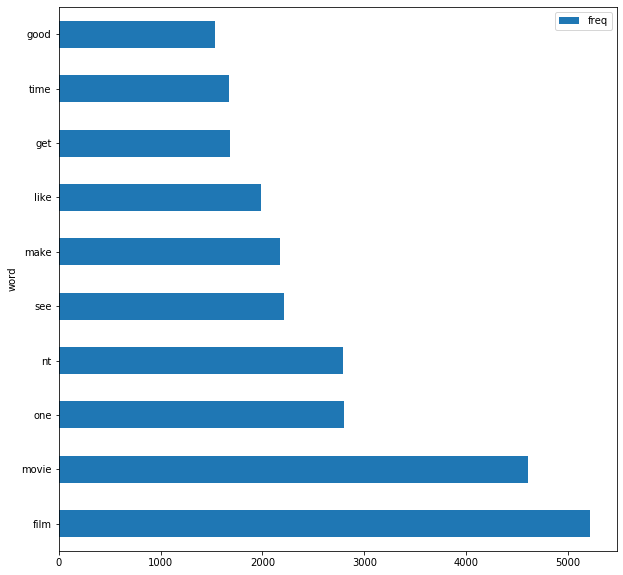

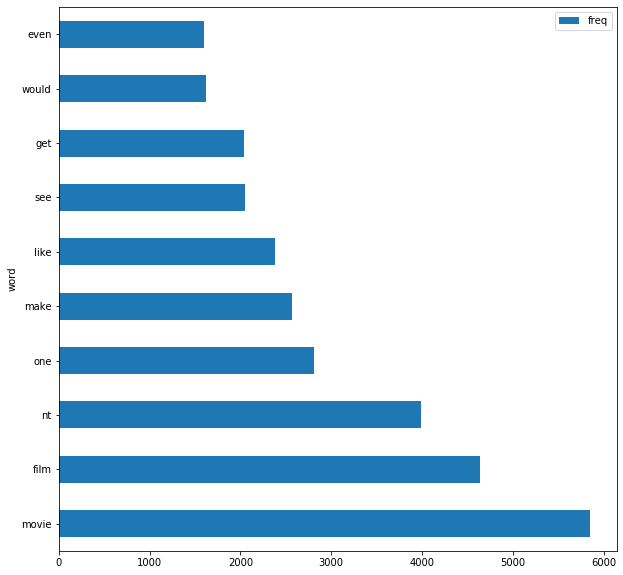

In [31]:
from matplotlib import pyplot as plt

top_negative_terms.plot(kind='barh', x='word', figsize=(10,10))
top_positive_terms.plot(kind='barh', x='word', figsize=(10,10))

In [21]:
from nltk.corpus import stopwords
stop_words = list((set(top_negative_terms.word) & set(top_positive_terms.word))|set(stopwords.words('english')))

### Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report, accuracy_score


nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])

nb.fit(x_train, y_train)

grid_params = {
    'clf__alpha': np.linspace(1e-4, 1e+5, 8),
    'clf__fit_prior': [True, False],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(100, 5000, 5, dtype = np.int)
}


clf = GridSearchCV(nb, grid_params, cv = 5, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print(clf.best_params_)

y_pred = nb.predict(x_test)
print('accuracy before %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

y_pred = clf.best_estimator_.predict(x_test)
print('accuracy after %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Best Score:  0.78
{'clf__alpha': 14285.71437142857, 'clf__fit_prior': False, 'vect__max_features': 2550, 'vect__ngram_range': (1, 1)}
accuracy before 0.8031111111111111
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      2277
           1       0.76      0.88      0.82      2223

    accuracy                           0.80      4500
   macro avg       0.81      0.80      0.80      4500
weighted avg       0.81      0.80      0.80      4500

accuracy after 0.8064444444444444
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      2277
           1       0.77      0.87      0.82      2223

    accuracy                           0.81      4500
   macro avg       0.81      0.81      0.81      4500
weighted avg       0.81      0.81      0.81      4500



In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import FunctionTransformer


nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
               ('clf', GaussianNB())
              ])

nb.fit(x_train, y_train)

grid_params = {
    'clf__var_smoothing': np.linspace(1e-9, 1e+5, 8),
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(100, 5000, 5, dtype = np.int)
}


clf = GridSearchCV(nb, grid_params, cv = 5, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print(clf.best_params_)

y_pred = nb.predict(x_test)
print('accuracy before %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

y_pred = clf.best_estimator_.predict(x_test)
print('accuracy after %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Best Score:  0.674
{'clf__var_smoothing': 1e-09, 'vect__max_features': 100, 'vect__ngram_range': (1, 1)}
accuracy before 0.6268888888888889
              precision    recall  f1-score   support

           0       0.66      0.54      0.59      2277
           1       0.60      0.72      0.65      2223

    accuracy                           0.63      4500
   macro avg       0.63      0.63      0.62      4500
weighted avg       0.63      0.63      0.62      4500

accuracy after 0.6788888888888889
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2277
           1       0.68      0.67      0.67      2223

    accuracy                           0.68      4500
   macro avg       0.68      0.68      0.68      4500
weighted avg       0.68      0.68      0.68      4500



In [24]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import FunctionTransformer


nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', BernoulliNB(binarize = None))
              ])

nb.fit(x_train, y_train)

grid_params = {
    'clf__alpha': np.linspace(1e-4, 1e+5, 8),
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(100, 5000, 5, dtype = np.int)
}


clf = GridSearchCV(nb, grid_params, cv = 5, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print(clf.best_params_)

y_pred = nb.predict(x_test)
print('accuracy before %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

y_pred = clf.best_estimator_.predict(x_test)
print('accuracy after %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Best Score:  0.752
{'clf__alpha': 0.0001, 'vect__max_features': 1325, 'vect__ngram_range': (1, 2)}
accuracy before 0.5046666666666667
              precision    recall  f1-score   support

           0       1.00      0.02      0.04      2277
           1       0.50      1.00      0.67      2223

    accuracy                           0.50      4500
   macro avg       0.75      0.51      0.35      4500
weighted avg       0.75      0.50      0.35      4500

accuracy after 0.7682222222222223
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      2277
           1       0.74      0.82      0.78      2223

    accuracy                           0.77      4500
   macro avg       0.77      0.77      0.77      4500
weighted avg       0.77      0.77      0.77      4500



In [25]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import FunctionTransformer


nb = Pipeline([('vect', CountVectorizer(max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', ComplementNB())
              ])

nb.fit(x_train, y_train)

grid_params = {
    'clf__alpha': np.linspace(1e-4, 1e+5, 8),
    'clf__fit_prior': [True, False],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(1000, 5000, 5, dtype = np.int),
}

clf = GridSearchCV(nb, grid_params, cv = 5, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print(clf.best_params_)

y_pred = nb.predict(x_test)
print('accuracy before %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

y_pred = clf.best_estimator_.predict(x_test)
print('accuracy after %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Best Score:  0.786
{'clf__alpha': 14285.71437142857, 'clf__fit_prior': True, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
accuracy before 0.8084444444444444
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      2277
           1       0.79      0.84      0.81      2223

    accuracy                           0.81      4500
   macro avg       0.81      0.81      0.81      4500
weighted avg       0.81      0.81      0.81      4500

accuracy after 0.8066666666666666
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      2277
           1       0.78      0.86      0.81      2223

    accuracy                           0.81      4500
   macro avg       0.81      0.81      0.81      4500
weighted avg       0.81      0.81      0.81      4500



## SGDClassifier

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

sgdc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier())
              ])

sgdc.fit(x_train, y_train)

grid_params = {
    'clf__alpha':  np.linspace(1e-4, 1e+5, 8),
    'clf__penalty': ['l2', 'l1'],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(1000, 5000, 5, dtype = np.int),
}

clf = GridSearchCV(sgdc, grid_params, cv = 5, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print(clf.best_params_)

y_pred = sgdc.predict(x_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

y_pred = clf.best_estimator_.predict(x_test)
print('accuracy after %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Best Score:  0.774
{'clf__alpha': 0.0001, 'clf__penalty': 'l1', 'vect__max_features': 3000, 'vect__ngram_range': (1, 2)}
accuracy 0.7926666666666666
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2277
           1       0.78      0.81      0.79      2223

    accuracy                           0.79      4500
   macro avg       0.79      0.79      0.79      4500
weighted avg       0.79      0.79      0.79      4500

accuracy after 0.7755555555555556
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2277
           1       0.76      0.80      0.78      2223

    accuracy                           0.78      4500
   macro avg       0.78      0.78      0.78      4500
weighted avg       0.78      0.78      0.78      4500



In [27]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', SVC(max_iter = 5000, kernel = 'rbf'))
              ])

svm.fit(x_train, y_train)

grid_params = {
    
    'clf__C':  np.linspace(1e-4, 1e+5, 8),
    'clf__kernel':  ['sigmoid', 'linear', 'poly', 'rbf'],
    'clf__degree': [2, 3],
    'clf__max_iter': [5000],
    'clf__gamma': ['scale', 'auto'],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(1000, 5000, 5, dtype = np.int)
    
}

clf = GridSearchCV(svm, grid_params, cv = 3, verbose= True, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

y_pred = svm.predict(x_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

y_pred = clf.best_estimator_.predict(x_test)
print('accuracy after %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  8.5min finished


Best Score:  0.7899622441863262
Best Params:  {'clf__C': 14285.71437142857, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__max_iter': 5000, 'vect__max_features': 1000, 'vect__ngram_range': (1, 2)}
accuracy 0.7966666666666666
              precision    recall  f1-score   support

           0       0.88      0.69      0.78      2277
           1       0.74      0.90      0.81      2223

    accuracy                           0.80      4500
   macro avg       0.81      0.80      0.79      4500
weighted avg       0.81      0.80      0.79      4500

accuracy after 0.792
              precision    recall  f1-score   support

           0       0.82      0.75      0.79      2277
           1       0.77      0.83      0.80      2223

    accuracy                           0.79      4500
   macro avg       0.79      0.79      0.79      4500
weighted avg       0.79      0.79      0.79      4500



- Лучше всего себя покзаал MultinomialNB класификатор
- В качетсве стоп слов использовалось пересечения множетсва полпулярных нег. и позит. терминов вместе с стандартными набором английских стоп слов
____
`
Best Score:  0.806
Best Params:  
'clf__C': 14285.7143, 
'clf__fit_prior': False, 
'clf__max_iter': 5000, 
'vect__max_features': 2550, 
'vect__ngram_range': (1, 1)
`

